# Investigating various ways to select positions of interest

## Imports

In [1]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pylab import rcParams
import seaborn as sns
from array import array
import math
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import linregress
from scipy.stats import mannwhitneyu
import statistics
%matplotlib inline

In [2]:
def synonymous (row):
    if row['null'] or (row['Consensus_aa']==row['Secondbase_aa'] ):
        return "synonymous" 
    else:
        return "non-synonymous"

def add_columns(table):
    table['null'] = (table['Secondbase_aa']).isnull()
    table['is_synonymous'] = table.apply (lambda row: synonymous (row),axis=1)
    table['1_major_variant_frequency'] = 1.0 - table['Major_variant_frequency_quality_corrected']
    
def is_increasing(minor_frequencies):
    #print(minor_frequencies)
    tolerance = 0.01
    minimum_increase = 0.1
    previous = minor_frequencies[0]
    if minor_frequencies[-1] - minor_frequencies[0] < minimum_increase:
        return False
    for m in range(1,len(minor_frequencies)):
        if previous < minor_frequencies[m] or previous < minor_frequencies[m] + tolerance:
            #print(str(previous) + " < " + str(minor_frequencies[m]))
            previous = minor_frequencies[m]
        else:
            return False
    return True


# Strict definition of an increasing position
def is_strictly_increasing(minor_frequencies):
    #print(minor_frequencies)
    previous = minor_frequencies[0]
    for m in range(1,len(minor_frequencies)):
        if previous < minor_frequencies[m]:
            #print(str(previous) + " < " + str(minor_frequencies[m]))
            previous = minor_frequencies[m]
        else:
            return False
    return True


def get_variant_frequency(variant, table, i):
    sum_of_bases = table['As_quality_corrected'][i]+table['Cs_quality_corrected'][i]+table['Gs_quality_corrected'][i]+table['Ts_quality_corrected'][i]+table['Ns_quality_corrected'][i]
    if variant == "A":
        return table["As_quality_corrected"][i] / sum_of_bases
    elif variant == "C":
        return table["Cs_quality_corrected"][i] / sum_of_bases
    elif variant == "G":
        return table["Gs_quality_corrected"][i] / sum_of_bases
    elif variant == "T":
        return table["Ts_quality_corrected"][i] / sum_of_bases
    else:
        return np.nan
        

def get_increasing_variants(tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    increasingVariants = dict()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        if major == last["Major_variant"][i]:
            minor = last["Second_variant"][i]
        else:
            minor = last["Major_variant"][i]
        minor_frequencies[0] = get_variant_frequency(minor, first, i)
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
            minor_frequencies[table_id] = get_variant_frequency(minor, tables[table_id], i)
        if is_increasing(minor_frequencies):
            increasingVariants[i] = [major_frequencies.tolist(), minor_frequencies.tolist()]
    return increasingVariants


def printMajorFrequencyThroughSamples(tables, numPos):
    major = tables[0]['Major_variant'][numPos]
    last_major = tables[0]['Major_variant'][numPos]
    print("Position "+ str(numPos) +", Major variant in first sample: " + major)
    print("Position "+ str(numPos) +", Frequencies of "+major+" through the samples: ")
    for i in range(len(tables)):
        print("\t"+str(get_variant_frequency(major, tables[i], numPos)))
    print("Position "+ str(numPos) +", Major variant in last sample: " + tables[-1]['Major_variant'][numPos])

    
def printMajorFrequencyThroughSamples_2340_7172(tables):
    printMajorFrequencyThroughSamples(tables, 2340)
    printMajorFrequencyThroughSamples(tables, 7172)
    
## Function to get colors by time points
def color_from_name (name, colors):
    if "3_" in name:
        return colors[0]
    if "6_" in name:
        return colors[1]
    if "9_" in name:
        return colors[2]
    if "12_" in name:
        return colors[3]
    if "18_" in name:
        return colors[4]
    if "24_" in name:
        return colors[5]
    if "51_" in name:
        return colors[6]
    else:
        print("PROBLEM: did not find " + name)

def colors_from_names (names):
    colors= list()
    pal = sns.color_palette( n_colors=7 )
    hexa_cols = pal.as_hex()
    for name in names:
        colors.append(color_from_name (name, hexa_cols) )
    return colors

# Reading the data

In [3]:
# Control runs, replicate A
DD3_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD3A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD3_A)
DD6_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD6_A)
DD9_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD9_A)
DD12_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD12A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD12_A)
DD18_A = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD18_A)
DD24_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD24A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD24_A)
DD51_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD51A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD51_A)
DD51_A_no_reamp = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD51Anoreamplification_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD51_A_no_reamp)

tables_A = [DD3_A, DD6_A, DD9_A, DD12_A, DD18_A, DD24_A, DD51_A]
names_A = ["DD3_A", "DD6_A", "DD9_A", "DD12_A", "DD18_A", "DD24_A", "DD51_A"]
colors_A = colors_from_names(names_A)

In [4]:
# Control runs, replicate D
DD3_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD3D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD3_D)
DD6_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD6_D)
DD9_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD9_D)
DD12_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD12D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD12_D)
DD18_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD18_D)
DD24_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD24D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD24_D)

tables_D = [DD3_D, DD6_D, DD9_D, DD12_D, DD18_D, DD24_D]
names_D = ["DD3_D", "DD6_D", "DD9_D", "DD12_D", "DD18_D", "DD24_D"]
colors_D = colors_from_names(names_D)

In [5]:
# Control runs, replicate E
DD3_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD3E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD6_E = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD9_E = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD12_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD12E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD18_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD24_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD24E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD24crude_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD24Ecrude_1_sequence.txt.assembled.fastq_mapped_AA.csv")

add_columns(DD3_E)
add_columns(DD6_E)
add_columns(DD9_E)
add_columns(DD12_E)
add_columns(DD18_E)
add_columns(DD24_E)
add_columns(DD24crude_E)

tables_E = [DD3_E, DD6_E, DD9_E, DD12_E, DD18_E, DD24_E]
names_E = ["DD3_E", "DD6_E", "DD9_E", "DD12_E", "DD18_E", "DD24_E"]
colors_E = colors_from_names(names_E)

In [6]:
# TLR3 activation runs, replicate A
TD9_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD9A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD9_A)
TD12_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD12A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD12_A)
TD18_A = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD18A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD18_A)
TD24_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD24A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD24_A)
TD51_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1TD51A_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD51_A)

tables_TA = [TD9_A, TD12_A, TD18_A, TD24_A, TD51_A]
names_TA = ["TD9_A", "TD12_A", "TD18_A", "TD24_A", "TD51_A"]
colors_TA = colors_from_names(names_TA)

In [7]:
# TLR3 activation runs, replicate D
TD9_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD9D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD12_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD12D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD18_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD18D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD24_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD24D_1_sequence.txt.assembled.fastq_mapped_AA.csv")

add_columns(TD9_D)
add_columns(TD12_D)
add_columns(TD18_D)
add_columns(TD24_D)

tables_TD = [TD9_D, TD12_D, TD18_D, TD24_D]
names_TD = ["TD9_D", "TD12_D", "TD18_D", "TD24_D"]
colors_TD = colors_from_names(names_TD)

In [8]:
# TLR3 activation runs, replicate E
TD9_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD9E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD12_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD12E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD18_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD18E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
TD24_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1TD24E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(TD9_E)
add_columns(TD12_E)
add_columns(TD18_E)
add_columns(TD24_E)

tables_TE = [TD9_E, TD12_E, TD18_E, TD24_E]

names_TE= [ "TD9_E", "TD12_E", "TD18_E", "TD24_E"]
colors_TE = colors_from_names(names_TE)

In [9]:
# All tables
all_tables = tables_A+tables_D+tables_E+tables_TA+tables_TD+tables_TE
all_table_names = ["DD3_A", "DD6_A", "DD9_A", "DD12_A", "DD18_A", "DD24_A", "DD51_A", "DD3_D", "DD6_D", "DD9_D", "DD12_D", "DD18_D", "DD24_D", "DD3_E", "DD6_E", "DD9_E", "DD12_E", "DD18_E", "DD24_E", "TD9_A", "TD12_A", "TD18_A", "TD24_A", "TD51_A", "TD9_D", "TD12_D", "TD18_D", "TD24_D", "TD9_E", "TD12_E", "TD18_E", "TD24_E"]

# Figure S5

### Computing standard deviation of base frequencies at a site in an experiment

In [10]:
# Functions to think in terms of standard deviation of the frequency per site
def compute_sds(tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    sds = list()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
        sd_value = statistics.pstdev(major_frequencies)
        sds.append(sd_value)
    return sds

def get_varying_variants_sd(tables, sd_threshold):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    varyingVariants = dict()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
        sd_value = statistics.pstdev(major_frequencies)
        if sd_value > sd_threshold:
            varyingVariants[i] = sd_value
    #print("There are "+str(len(varyingVariants))+" positions whose major variant varies a lot in frequency.")
    #print("Those are:")
    #print(varyingVariants.keys())
    return varyingVariants


### Defining a threshold of variation

In [11]:
# Compute all standard deviations for all sites for all experiments
sds_A = compute_sds(tables_A)
sds_D = compute_sds(tables_D)
sds_E = compute_sds(tables_E)
sds_TA = compute_sds(tables_TA)
sds_TD = compute_sds(tables_TD)
sds_TE = compute_sds(tables_TE)


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


In [12]:
sds = list()
sds = sds + sds_A + sds_D + sds_E + sds_TA + sds_TD + sds_TE


/home/boussau/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/boussau/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


[Text(0,0.5,'Density'),
 Text(0.5,0,'Standard deviation of base frequencies, with 2 thresholds (0.015 and 0.1)')]

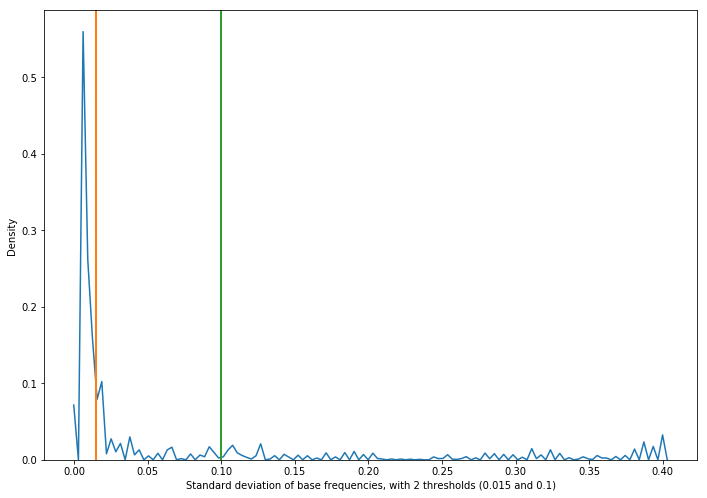

In [13]:
a4_dims = (11.7, 8.27)


fig, ax = plt.subplots(figsize=a4_dims)

sns.kdeplot(sds)
sds_threshold = 0.015
alternative_threshold = 0.1
plt.plot([sds_threshold, sds_threshold], [0, 1], linewidth=2)
plt.plot([alternative_threshold, alternative_threshold], [0, 1], linewidth=2)
ax.set(xlabel='Standard deviation of base frequencies, with 2 thresholds (0.015 and 0.1)', ylabel='Density')


In [14]:
num =0
for i in sds:
    if (i>sds_threshold):
        num = num +1
print("There are "+str(num) + " pairs position*experiments that have a standard deviation larger than the threshold "+str(sds_threshold))

There are 125 pairs position*experiments that have a standard deviation larger than the threshold 0.015


In [15]:
num =0
for i in sds:
    if (i>alternative_threshold):
        num = num +1
print("There are "+str(num) + " pairs position*experiments that have a standard deviation larger than the threshold "+str(alternative_threshold))

There are 54 pairs position*experiments that have a standard deviation larger than the threshold 0.1


### Retrieving the highly variable variants

In [16]:
def getAllVaryingVariants (tables_A, tables_D, tables_E, tables_TA, tables_TD, tables_TE, threshold):
    varying_A = get_varying_variants_sd(tables_A, threshold)
    varying_D = get_varying_variants_sd(tables_D, threshold)
    varying_E = get_varying_variants_sd(tables_E, threshold)
    varying_TA = get_varying_variants_sd(tables_TA, threshold)
    varying_TD = get_varying_variants_sd(tables_TD, threshold)
    varying_TE = get_varying_variants_sd(tables_TE, threshold)
    return [varying_A, varying_D, varying_E, varying_TA, varying_TD, varying_TE]

In [17]:
all_varying = getAllVaryingVariants(tables_A, tables_D, tables_E, tables_TA, tables_TD, tables_TE, sds_threshold)

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


In [18]:
def build_table_for_plotting_varying_pos (all_varying):
    all_keys = list()
    for di in all_varying:
        all_keys = all_keys + list(di.keys())
    return(Counter(all_keys))

def get_counts_from_varying_variants (all_varying):
    counts = build_table_for_plotting_varying_pos(all_varying)
    return counts

In [19]:
def plot_counts (counts, threshold):
    counts_sorted = sorted(counts.items())
    labels, values = zip(*counts_sorted)

    indexes = np.arange(len(labels))
    width = 1

    sns.set_palette("hls")
    sns.set_context("poster")
    a4_dims = (14.7, 14.27)
    to_plot = pd.DataFrame ({'Position':indexes, 'standard_deviation':values}) 
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.barplot(y="Position", x="standard_deviation", data=to_plot, orient="h")
    ax.set(xlabel='Number of samples where standard deviation is above ' + str(threshold), ylabel='Position in the genome')
    plt.yticks(indexes + width * 0.5, labels, size=10)
    plt.show()

There are 84 varying variants.


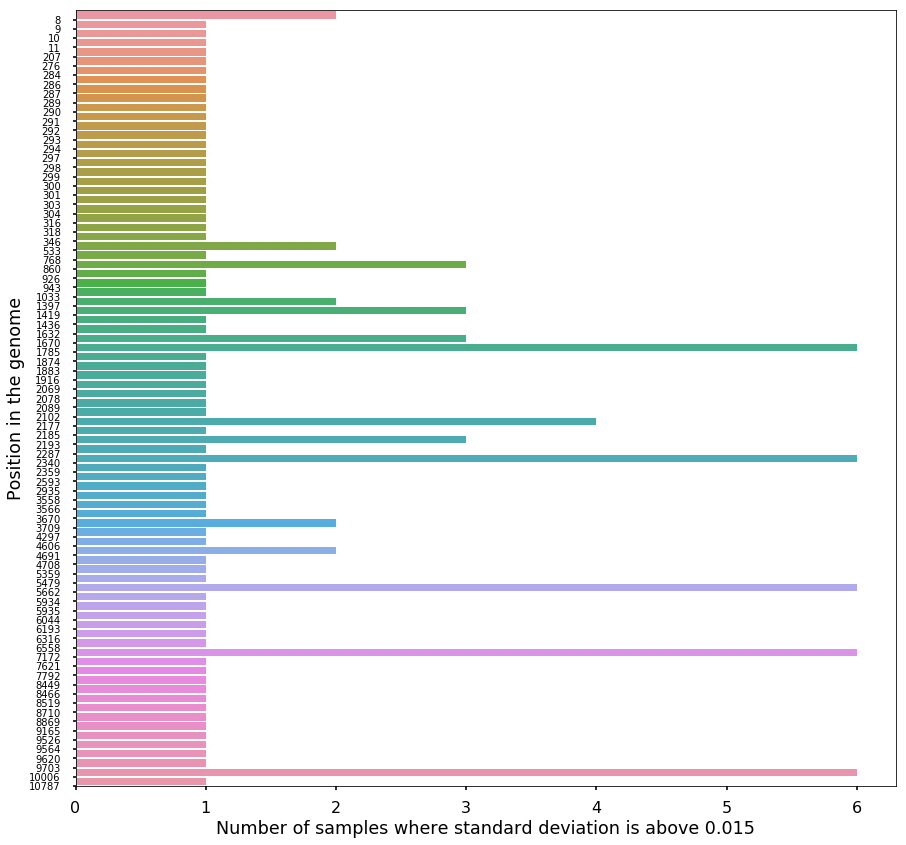

In [20]:
counts = get_counts_from_varying_variants(all_varying)
print("There are "+str(len(counts))+ " varying variants.")
plot_counts (counts, sds_threshold)

# Investigating a threshold on standard deviation of 0.1

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


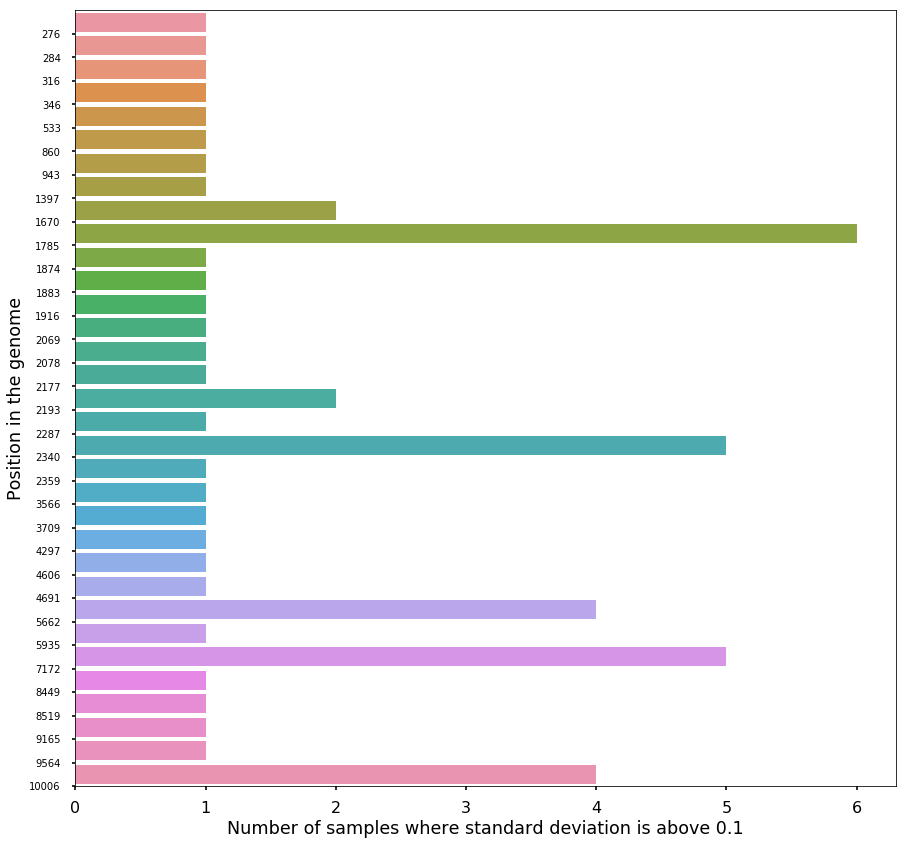

In [21]:
all_varying_01 = getAllVaryingVariants(tables_A, tables_D, tables_E, tables_TA, tables_TD, tables_TE, 0.1)
counts_01 = get_counts_from_varying_variants(all_varying_01)
plot_counts (counts_01, 0.1)